In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, svds, eigs
from math import sqrt
import scipy.io as sio
import random
import numpy.matlib
# fix the seed
random.seed( 3 )

In [3]:
# Load data
Problem = sio.loadmat('clustering_data.mat')
C = np.double(Problem['C']) # euclidean distance matrix
N = np.int(Problem['N']) # number of data points
k = Problem['k'] # number of clusters
opt_val = Problem['opt_val'] # optimum value 

In [4]:
## Define operators
# We provide 4 operators:
# 1- A1: Linear operator that takes the row sums
# 2- At2: Conjugate of operator A1
# 3- A2: Linear operator that takes the column sums 
# 4- At2: Conjugate of operator A2
A1 = lambda x: np.sum(x, axis = 1)
At1 = lambda y: np.transpose(np.matlib.repmat(y, N, 1))
A2 = lambda x: np.sum(x, axis = 0)
At2 = lambda y: (np.matlib.repmat(y, N, 1))

b = np.double(np.ones(N))

In [17]:
# Plotting function
def plot_func(cur_iter, feasibility1,feasibility2, objective, X):
    plt.figure(figsize=(15, 8))
    plt.subplot(221)
    plt.loglog(cur_iter, feasibility1)
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('$\|X1-1\|/1$',fontsize=15)
    plt.grid(True)

    plt.subplot(222)
    plt.loglog(cur_iter, feasibility2)
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('dist$(X, \mathbb{R}^{n}_+)$',fontsize=15)
    plt.grid(True)
    plt.subplots_adjust(wspace=0.35)
    plt.savefig('Images/feasibility1.png')
    plt.show()

    #plt.subplot(223)
    obj_res = np.reshape(np.abs(objective - opt_val)/opt_val, (len(objective),))
    plt.figure(figsize=(12, 8))
    plt.loglog((cur_iter), (obj_res))
    plt.xlabel('iteration',fontsize=15)
    plt.ylabel('$\|f(X) - f^*\|/f^*$',fontsize=15)
    plt.title('Relative objective residual',fontsize=15)
    plt.grid(True)
    plt.savefig('Images/objective.png')
    plt.show()
    
    plt.figure(figsize=(12, 8))
    plt.imshow(X)
    plt.title('SDP solution',fontsize=15)
    plt.savefig('Images/x.png')
    plt.show()

In [24]:
def HomotopyCGM(kappa=10, maxit=np.int(1e3), beta0=1):
    # Initialize
    X = np.zeros((N,N))
    AX1_b = 0.0
    
    feasibility1 = [] # norm(A1(X)-b1)/norm(b1)
    feasibility2 = [] # dist(X, \mathcal{K})
    objective    = [] # f(x)
    cur_iter    = [] 
    
    iter_track = np.unique(np.ceil(np.power(2, np.linspace(0,20,50))))
    
    for iteration in range(1, maxit+1):
        
        # Update Step Size
        gamma = 2.0/(iteration + 1.0)
        
        # Update beta
        beta_ = beta0 /(sqrt(iteration + 1.0))
        
        # Write down the vk to use in the lmo (eigenvalue routine)
        vk = beta_ * C + At1(A1(X) - b) + At2(A2(X) - b) + 1000*(X - np.maximum(X,0))
        vk = 0.5*(vk + vk.T)
        
        # Linear minimization oracle
        # use eigsh function with proper settings to calculate the lmo
        # See Reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.eigsh.html#scipy.sparse.linalg.eigsh 
        q, u = eigsh(vk, 1, which='SA')
        u = sqrt(kappa)*u
        X_bar = np.outer(u,u)
        
        # Obtain A*Xbar - b
        AX_bar_b = A1(X_bar)-b
        
        # Update A*X - b
        AX1_b = (1.0-gamma)*AX1_b + gamma*(AX_bar_b)
        
        # Update X
        X = (1.0 - gamma)*X + gamma*X_bar
                
        if any(iteration == iter_track) or iteration==maxit:
            feasibility1.append(np.linalg.norm(AX1_b)/N) 
            feasibility2.append(np.linalg.norm(np.minimum(X,0), ord='fro'))# distance to positive orthant
            objective.append(np.sum(C.flatten()*X.flatten()))
            cur_iter.append(iteration)
            print('{:03d} | {:.4e}| {:.4e}| {:.4e}|'.format(iteration, feasibility1[-1], feasibility2[-1],objective[-1]))
            
    return X, feasibility1, feasibility2, objective, cur_iter

In [35]:
# Run the algorithm
X, feasibility1, feasibility2, objective, cur_iter = HomotopyCGM(10, np.int(1e4), 1)

001 | 2.8157e-01| 0.0000e+00| 1.5028e+04|
002 | 7.2775e-02| 2.8124e+00| 4.0633e+03|
003 | 3.8797e-02| 2.8820e+00| 1.7951e+03|
004 | 6.0178e-02| 1.6950e+00| 2.1542e+03|
005 | 4.4115e-02| 1.8916e+00| 2.3621e+03|
006 | 3.9321e-02| 1.3341e+00| 2.1423e+03|
008 | 3.1495e-02| 1.3564e+00| 1.9023e+03|
010 | 2.7986e-02| 1.0876e+00| 1.7042e+03|
013 | 9.1450e-03| 1.1454e+00| 8.7334e+02|
017 | 9.7534e-03| 8.7930e-01| 8.0521e+02|
023 | 1.0672e-02| 6.6643e-01| 8.7141e+02|
030 | 7.5734e-03| 4.7975e-01| 7.2881e+02|
040 | 7.0140e-03| 3.3010e-01| 6.7838e+02|
053 | 4.0745e-03| 3.2327e-01| 5.9426e+02|
070 | 3.7769e-03| 2.4258e-01| 5.2277e+02|
093 | 3.1013e-03| 2.2820e-01| 4.2056e+02|
123 | 2.7919e-03| 1.7647e-01| 4.7091e+02|
163 | 1.9039e-03| 1.5112e-01| 4.6101e+02|
217 | 1.4484e-03| 9.8330e-02| 5.0076e+02|
287 | 1.3245e-03| 7.9814e-02| 4.8056e+02|
381 | 1.1133e-03| 5.0463e-02| 4.6129e+02|
505 | 8.4110e-04| 4.5277e-02| 3.8388e+02|
670 | 7.7789e-04| 4.1935e-02| 3.1975e+02|
889 | 6.6830e-04| 3.5774e-02| 2.52

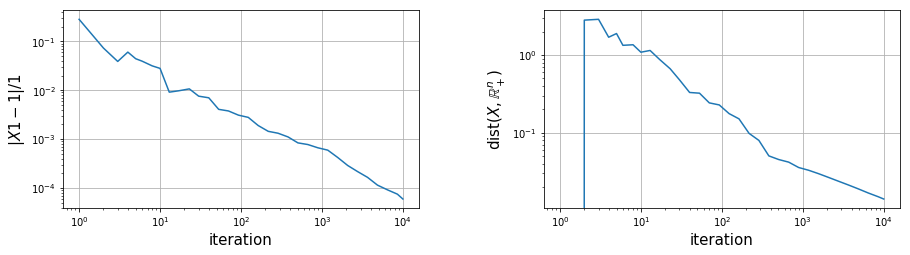

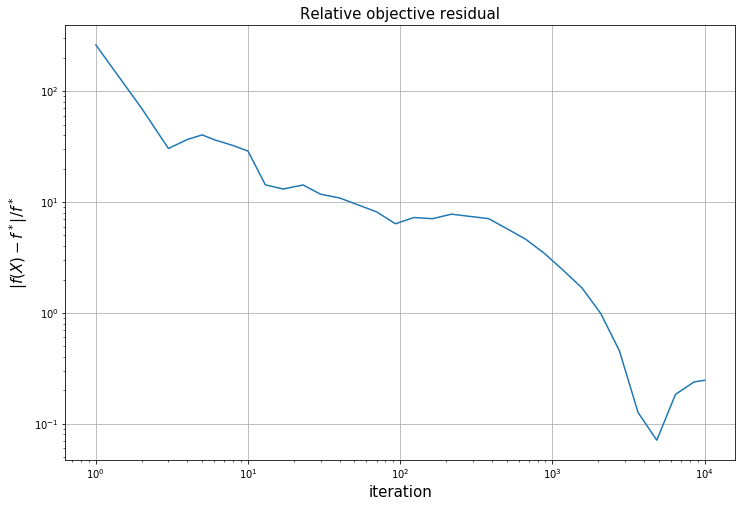

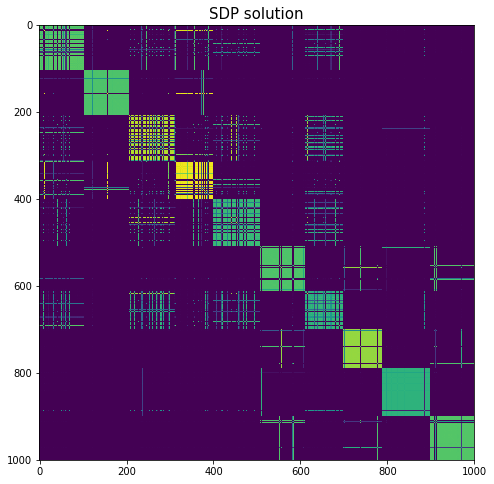

In [36]:
# Plot the results
plot_func(cur_iter, feasibility1,feasibility2, objective, X)

<function matplotlib.pyplot.show>

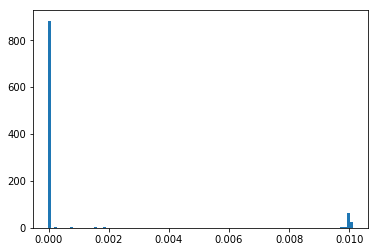

In [37]:
plt.figure()
plt.hist(X[0,:], bins=100)
plt.show